# Create the Bayesian Network

In [1]:
import pandas as pd
import pickle
from pgmpy.models import BayesianNetwork
import networkx as nx
from utils import hierarchical_layout,draw_graph

# Import the pre-processed dataset and its values mapping
data = pd.read_csv("./dataset_final.csv")
with open('label_mappings.pkl', 'rb') as f: label_mappings = pickle.load(f)

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Different models

1. [Model-1: Baseline network](#model-1-baseline-network)
2. [Model-2: Network with a latent variable ](#model-2-network-with-a-latent-variable)
3. [Model-3: Network with unified variables](#model-3-network-with-unified-variables)

### Model-1: Baseline network

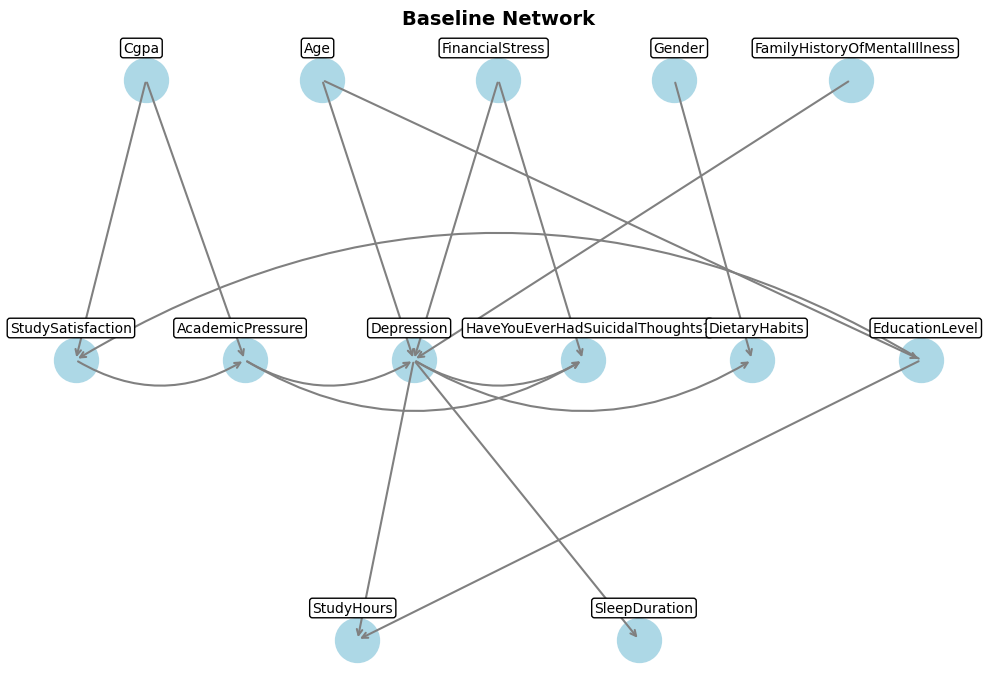

In [2]:
# Define the network structure
network_baseline = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Depression"),
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Depression"),
    ("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_baseline = BayesianNetwork(network_baseline)

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_baseline.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Baseline Network")

### Model 2: Network with a latent variable

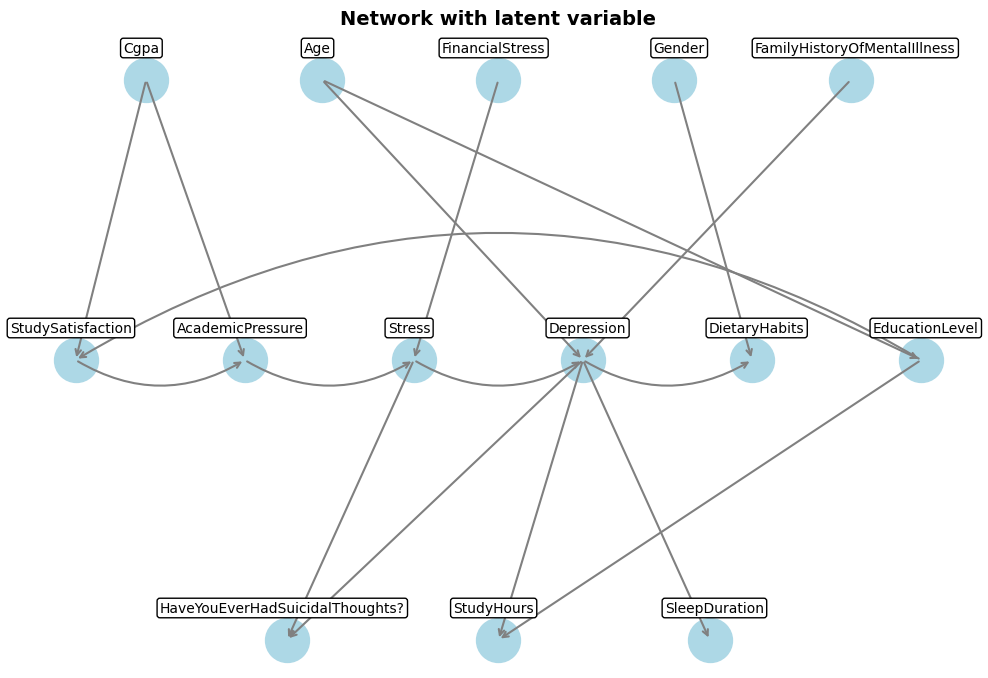

In [3]:
# Define the network structure
network_latent = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Stress"),                              # added Stress
    ("Stress","Depression"),                                    # added Stress
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Stress"),                               # added Stress
    ("Stress","Depression"),                                    # added Stress
    #("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    #("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_latent = BayesianNetwork(network_latent, latents=["Stress"])

# Plot its graph
R = nx.DiGraph()
R.add_edges_from(BN_latent.edges())
pos = hierarchical_layout(R, horizontal_spacing=3.0)
draw_graph(R, pos, title="Network with latent variable")

### Model 3: Network with unified variables

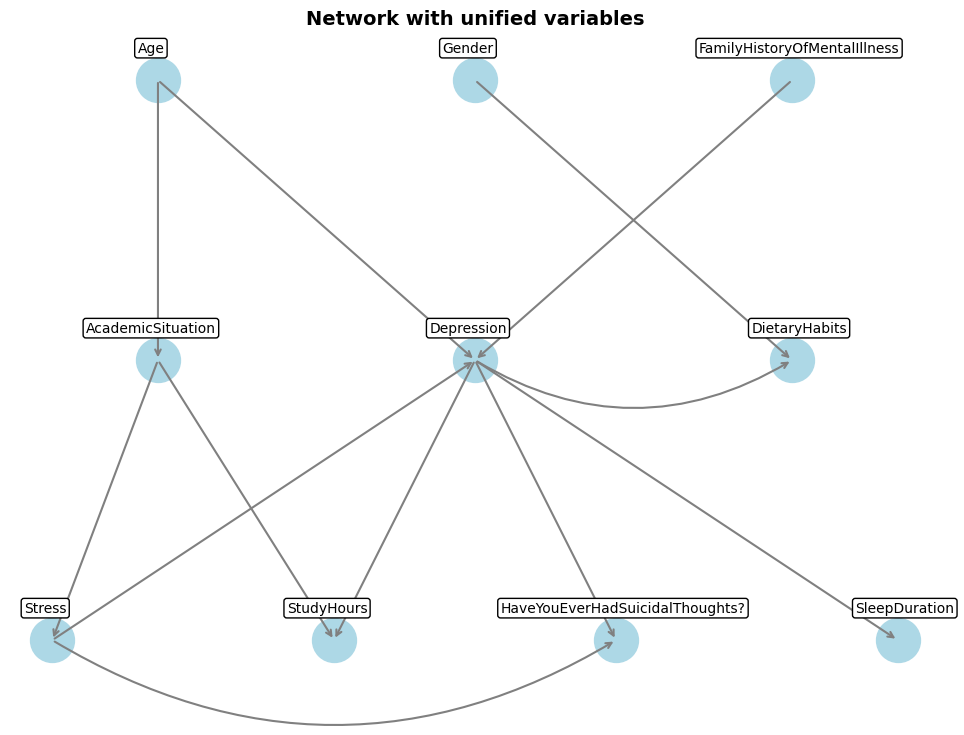

In [4]:
# Define the network structure
network_unified = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("AcademicSituation","Stress"),
    # ("AcademicSituation", "AcademicSituation"),
    ("Stress","Depression"),
    ("AcademicSituation","Stress"),
    ("Age","AcademicSituation"),
    ("Stress","Depression"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    # ("AcademicSituation", "AcademicSituation"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("AcademicSituation","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_unified = BayesianNetwork(network_unified)

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_unified.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Network with unified variables")

## Fit models

In [5]:
models = {
    #"Baseline Network" : BN_baseline, 
     "Network with latent variable" : BN_latent, 
    # "Network with unified variables" : BN_unified
}
data_new = data.drop(columns=["EducationCategory", "Regions"])

In [6]:
from pgmpy.estimators import ExpectationMaximization, BayesianEstimator
random_seed = 42

# Fit Bayesian Network using Expectation-Maximization
for name, mod in models.items():    
    # We explicitly fit since otherwise we can't set the seed
    em = ExpectationMaximization(mod, data_new)
    estimated_params = em.get_parameters(seed=random_seed, max_iter=40)
    mod.cpds = estimated_params
    if not mod.check_model() : print(f'Model \"{name}\" check failed')

100%|██████████| 40/40 [05:50<00:00,  8.77s/it]


In [10]:
models.items()

dict_items([('Network with latent variable', <pgmpy.models.BayesianNetwork.BayesianNetwork object at 0x17a5d4550>)])

In [11]:
from pgmpy.estimators import ExpectationMaximization, BayesianEstimator
BN_baseline.fit(data_new, estimator=BayesianEstimator)
#BN_latent.fit(data_new, BayesianEstimator)

NameError: name 'B' is not defined

In [12]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import pandas as pd
import numpy as np

def log_like_score(model, df):
    inference = VariableElimination(model)
    log_likelihood = 0
    for i in range(len(df)):
        row = df.iloc[i]
        for col in df.columns:
            evidence = {col1: row[col1] for col1 in df.drop(columns=col).columns}
            result = inference.query(variables=[col], evidence=evidence)
            #Calcola la probabilità congiunta del punto dati
            #prob_joint = result.values.sum(axis=)
            if (((col=='Cgpa') and row[col]>0) or (col=='FinancialStress')):
                log_likelihood += np.log(result.values[row[col]-1])
            else:
                log_likelihood += np.log(result.values[row[col]])
                
    return log_likelihood

In [13]:
import numpy as np
from pgmpy.models import BayesianNetwork

def count_bn_parameters(model: BayesianNetwork) -> int:
    """
    Compute the total number of free parameters in a discrete Bayesian Network.
    
    For each node X with r states and parents with product of cardinalities Q,
    the number of free parameters is (r - 1) * Q.
    
    Parameters:
        model: BayesianNetwork
            The Bayesian network model with CPDs defined.
    
    Returns:
        total_parameters: int
            The total number of free parameters in the network.
    """
    total_parameters = 0
    for cpd in model.get_cpds():
        r = cpd.cardinality[0]  # Cardinality of the variable
        Q = np.prod(cpd.cardinality[1:]) if len(cpd.cardinality) > 1 else 1  # Product of parent cardinalities
        free_params = (r - 1) * Q
        total_parameters += free_params
        
    return total_parameters

# Example usage:
# Assume you have a Bayesian network model called BN_baseline with CPDs defined.
# total_params = count_bn_parameters(BN_baseline)
# print("Total number of free parameters:", total_params)


In [ ]:
count_bn_parameters(BN_baseline)

np.int64(710)

In [14]:
count_bn_parameters(BN_latent)

np.int64(460)

In [ ]:
from pgmpy.metrics import log_likelihood_score
log_likelihood_score(BN_baseline, data_new)

np.float64(-407433.2190509852)

In [15]:
def compute_bic(model, data):
    """
    Computes the Bayesian Information Criterion (BIC) score for a given Bayesian Network model and dataset.
    
    Parameters:
        model (BayesianNetwork): The Bayesian Network model.
        data (pd.DataFrame): A DataFrame where each row represents an observation with observed variable values.
    
    Returns:
        float: The BIC score of the model given the dataset.
    """
    log_likelihood = log_like_score(model, data)
    num_params = sum(np.prod(cpd.cardinality) - 1 for cpd in model.get_cpds())  # Total number of parameters
    num_samples = len(data)  # Number of data points
    
    bic = log_likelihood - (num_params / 2) * np.log(num_samples)
    return bic

compute_bic(BN_latent, data_new)

np.float64(-395695.1586979824)

In [16]:
compute_bic(BN_baseline, data_new)

np.float64(-397618.6621679389)

In [18]:
(-397618.6621679389)-(-395695.1586979824)

-1923.503469956515

In [ ]:
from pgmpy.estimators import BicScore
bic=BicScore(data_new)
bic.score(BN_baseline)

np.float64(-409715.87255623494)

## Evaluate Models

In [ ]:
evaluation_df = pd.DataFrame({
    "" : [],
})

for name, mod in models.items():    
    ...
    evaluation_df.iloc[len(evaluation_df)] = []
    
display(evaluation_df.sort_values(by=""))

IndexError: iloc cannot enlarge its target object